In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Set seed
np.random.seed(123)

# Set intial price and strike price
S0 = 100
K = 125

# Set GBM parameters
mu = 0.05
sigma = 0.2

# Set Heston parameters
v0 = sigma**2
kappa = 2
theta = 0.04
sigma_v = 0.3
rho = 0.5

# Set Jump diffusion parameters
lam = 1
mu_J = 0.05
sigma_J = 0.1

# Set time parameters
t0 = 0
T = 1
N = 250
M = 1000

# Compute time increments
dt = T/N
steps = int(np.round((T - t0) / dt))
time_grid = np.linspace(t0, T, N + 1)



In [27]:
# ===========================
# GBM
# ===========================
# Simulate S for S_GBM 
dW_gbm = np.random.normal(
    loc=0.0, 
    scale=np.sqrt(dt), 
    size=(M, steps - 1)          # M x (steps-1)
)    

# multiplicative factors
increments = 1 + mu * dt + sigma * dW_gbm
increments = np.hstack((
    np.ones((M, 1)),             # coluna inicial para t0
    increments
))                                # M x steps

S_gbm = S0 * np.cumprod(increments, axis=1)  # M x steps

# ===========================
# Heston
# ===========================
cov = np.array([[1.0, rho], [rho, 1.0]])

# Brownianos correlacionados (W1 para S, W2 para v)
dW_heston = np.random.multivariate_normal(
    mean=[0.0, 0.0], 
    cov=cov, 
    size=(M, steps - 1)
) * np.sqrt(dt)                   # M x (steps-1) x 2

dW1_heston = dW_heston[:, :, 0]   # M x (steps-1)
dW2_heston = dW_heston[:, :, 1]   # M x (steps-1)

# paths: mesmo número de colunas que S_gbm
S_heston = np.zeros((M, steps))
v_heston = np.zeros((M, steps))

S_heston[:, 0] = S0
v_heston[:, 0] = v0

# --- Alfonsi updates for v_t ---
for n in range(1, steps):
    v_prev = v_heston[:, n - 1]
    v_heston[:, n] = (
        v_prev
        + kappa * theta * dt 
        + sigma_v * np.sqrt(np.maximum(v_prev, 0)) * dW2_heston[:, n - 1]
        + 0.25 * sigma_v**2 * dt
    ) / (1 + kappa * dt)

# --- Euler multiplicativo para S_t ---
increments_heston = 1 + mu * dt + np.sqrt(np.maximum(v_heston[:, :-1], 0)) * dW1_heston
# v_heston[:, :-1] e dW1_heston são M x (steps-1)

S_heston[:, 1:] = S0 * np.cumprod(increments_heston, axis=1)

# ===========================
# Jump diffusion (Merton)
# ===========================
# Poisson increments e tamanhos de salto
dN_jump = np.random.poisson(lam * dt, size=(M, steps - 1))     # M x (steps-1)
J = np.exp(np.random.normal(mu_J, sigma_J, size=(M, steps - 1)))  # M x (steps-1)

S_jump = np.zeros((M, steps))
S_jump[:, 0] = S0

# Increments no mesmo grid do GBM: usa dW_gbm já gerado
increments_jump = 1 + mu * dt + sigma * dW_gbm + (J - 1.0) * dN_jump  # M x (steps-1)
S_jump[:, 1:] = S0 * np.cumprod(increments_jump, axis=1)

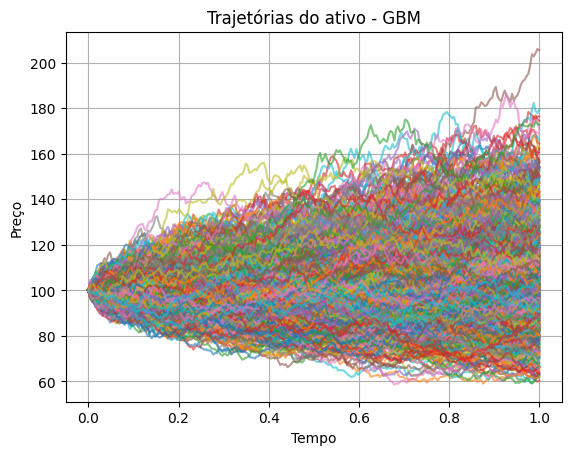

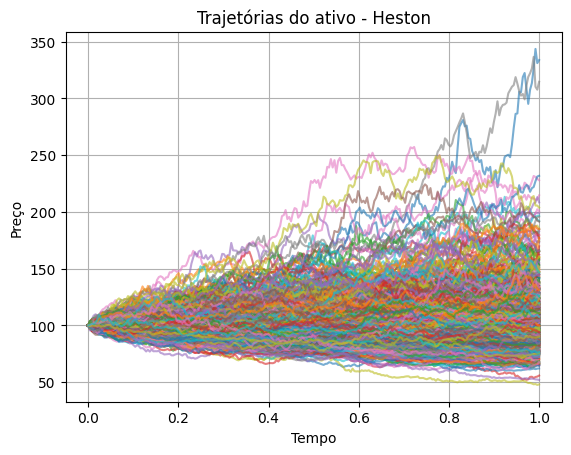

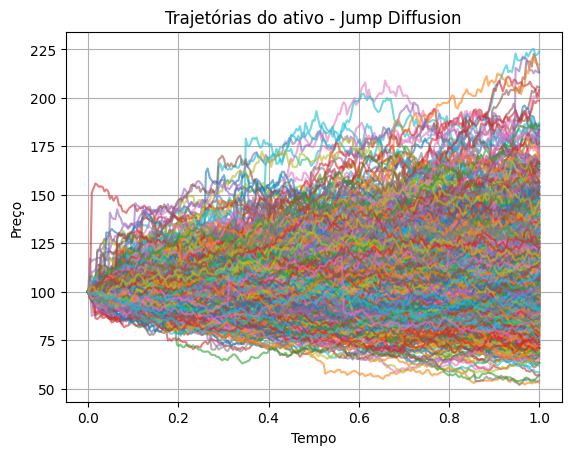

In [28]:
# Grade de tempo compatível com o número de colunas das matrizes simuladas
t_plot = np.linspace(t0, T, S_gbm.shape[1])

# --- GBM ---
plt.figure()
plt.plot(t_plot, S_gbm[:].T, alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("Preço")
plt.title("Trajetórias do ativo - GBM")
plt.grid(True)

# --- Heston ---
plt.figure()
plt.plot(t_plot, S_heston[:].T, alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("Preço")
plt.title("Trajetórias do ativo - Heston")
plt.grid(True)

# --- Jump Diffusion ---
plt.figure()
plt.plot(t_plot, S_jump[:].T, alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("Preço")
plt.title("Trajetórias do ativo - Jump Diffusion")
plt.grid(True)

plt.show()


## Ideia no caso GBM: aprender \(H(t,S)\) com rede neural usando as trajetórias já simuladas

Suponha que temos um ativo seguindo um GBM

\[
dS_t = \mu S_t\,dt + \sigma S_t\,dW_t,
\]

e um payoff terminal \(G(S_T)\) (por exemplo, uma call europeia \(G(s) = \max(s-K,0)\)).

Já simulamos \(M\) trajetórias de \(S_t\) em uma grade de tempos
\[
t_0 = 0 < t_1 < \dots < t_N = T,
\]
e temos uma matriz

\[
S_{\text{paths}} \in \mathbb{R}^{M \times (N+1)}, \quad
S_{\text{paths}}[m, i] \approx S_{t_i}^{(m)}.
\]

Queremos aproximar a função

\[
H(t,S) := \mathbb{E}\big[ G(S_T) \,\big|\, S_t = S \big],
\]

que é exatamente a solução “tipo Feynman–Kac” que aparece na formulação via FBSDE.

A estratégia é:

1. Definir uma rede neural \(N_H(t,S;\theta)\) (por exemplo, um MLP simples) para aproximar \(H(t,S)\).

2. Construir um *dataset* a partir das trajetórias já simuladas:
   - para cada trajetória \(m = 1,\dots,M\) e cada tempo \(t_i\),
     usamos como **entrada** o par \((t_i, S_{t_i}^{(m)})\);
   - como **alvo** (target), usamos sempre o mesmo payoff terminal
     \[
     Y^{(m)} = G\big(S_T^{(m)}\big),
     \]
     pois, condicionalmente a toda a trajetória \(S_\cdot^{(m)}\), vale
     \[
     H(t_i, S_{t_i}^{(m)}) = \mathbb{E}\!\left[ G(S_T) \mid S_{t_i} = S_{t_i}^{(m)} \right],
     \]
     e o mínimo de erro quadrático médio em relação a \(G(S_T^{(m)})\) é precisamente essa esperança condicional.

3. Treinar a rede \(N_H\) minimizando o MSE
   \[
   \min_\theta \; \mathbb{E}\left[
       \big( G(S_T) - N_H(t, S_t; \theta) \big)^2
   \right],
   \]
   aproximado pela média empírica sobre todos os pares \((t_i, S_{t_i}^{(m)})\).

4. Depois do treinamento, usamos:
   - \(H(t_i, S_{t_i}^{(m)}) \approx N_H\big(t_i, S_{t_i}^{(m)}; \theta^\*\big)\);
   - a derivada espacial necessária na decomposição de Itô é obtida por *autodiff*:
     \[
     H_S(t_i, S_{t_i}^{(m)}) \approx \frac{\partial}{\partial S}
     N_H\big(t_i, S; \theta^\*\big)\Big|_{S = S_{t_i}^{(m)}}.
     \]

No caso GBM unidimensional, isso já fornece tudo que precisamos para os coeficientes de \(dH_t\) no algoritmo de hedge:

\[
dH_t^{GBM}
= \left( \partial_t H + \mu S_t \partial_S H + \tfrac12 \sigma^2 S_t^2 \partial_{SS}H \right) dt
  + \sigma S_t \partial_S H \, dW_t,
\]

onde:
- \(\partial_S H\) vem diretamente do gradiente da rede neural em relação a \(S\);
- \(\partial_{SS}H\) pode ser obtida, se necessário, pela segunda derivada (Hessiano) via *autodiff*.

Esses termos alimentam os coeficientes de \(dL_t = dV_t^h - dH_t\) e, portanto,
\((b_L, \sigma_L)\) utilizados no forward do lucro e, mais adiante, no Hamiltoniano e no hedge ótimo.


In [29]:
# ============================================================
# 1) Dados a partir das paths já simuladas (usa S_gbm, t0, T, K)
# ============================================================

# Conversão para tensores
S_paths = torch.from_numpy(S_gbm).float()          # (M, steps)
M_, steps_ = S_paths.shape

# Grade de tempo compatível
t_grid = torch.linspace(t0, T, steps_)             # (steps,)

# Payoff terminal em cada trajetória (ex: call europeia)
S_T = S_paths[:, -1]                               # (M,)
payoff_T = torch.clamp(S_T - K, min=0.0)           # G(S_T)

# Construir dataset (t, S_t) -> G(S_T)
# (M * steps) amostras no total
t_list = []
S_list = []
Y_list = []

for m in range(M_):
    for i in range(steps_):
        t_list.append(t_grid[i])
        S_list.append(S_paths[m, i])
        Y_list.append(payoff_T[m])                 # mesmo alvo para todos os t daquela path

t_tensor = torch.stack(t_list)[:, None]            # (M*steps, 1)
S_tensor = torch.stack(S_list)[:, None]            # (M*steps, 1)
X_tensor = torch.cat([t_tensor, S_tensor], dim=1)  # (M*steps, 2)
Y_tensor = torch.stack(Y_list)[:, None]            # (M*steps, 1)

# ============================================================
# 2) Rede neural para H(t,S)
# ============================================================

class NetH(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

model = NetH()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ============================================================
# 3) Treinamento
# ============================================================

batch_size = 2048
n_epochs = 50

dataset = torch.utils.data.TensorDataset(X_tensor, Y_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(n_epochs):
    for X_batch, Y_batch in loader:
        pred = model(X_batch)
        loss = loss_fn(pred, Y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # opcional: print(f"Epoch {epoch+1}, loss = {loss.item():.6f}")

# ============================================================
# 4) Cálculo de H, dH/dt, dH/dS e d2H/dS2 em todos os pontos (t_i, S_t)
# ============================================================

# Clonar tensores e marcar grad
t_flat = t_tensor.clone().detach().requires_grad_(True)   # (M*steps, 1)
S_flat = S_tensor.clone().detach().requires_grad_(True)   # (M*steps, 1)

X_flat = torch.cat([t_flat, S_flat], dim=1)               # (M*steps, 2)

# H(t,S)
H_flat = model(X_flat)                                    # (M*steps, 1)

# Primeiras derivadas: dH/dt e dH/dS
dH_dt_flat, dH_dS_flat = torch.autograd.grad(
    outputs=H_flat.sum(),          # escalar
    inputs=[t_flat, S_flat],
    create_graph=True              # preciso para segunda derivada
)

# Segunda derivada em S: d^2 H / dS^2
d2H_dS2_flat = torch.autograd.grad(
    outputs=dH_dS_flat.sum(),      # escalar
    inputs=S_flat
)[0]

# Remodelar tudo para (M, steps)
H_vals    = H_flat.detach().view(M_, steps_)      # H(t, S_t)
H_t_vals  = dH_dt_flat.detach().view(M_, steps_)  # ∂H/∂t
H_S_vals  = dH_dS_flat.detach().view(M_, steps_)  # ∂H/∂S
H_SS_vals = d2H_dS2_flat.detach().view(M_, steps_)# ∂²H/∂S²


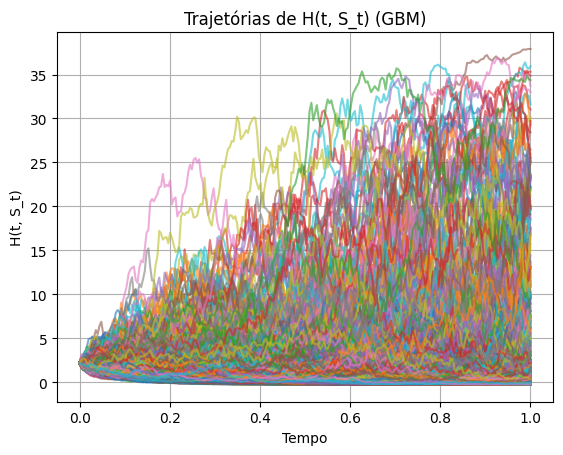

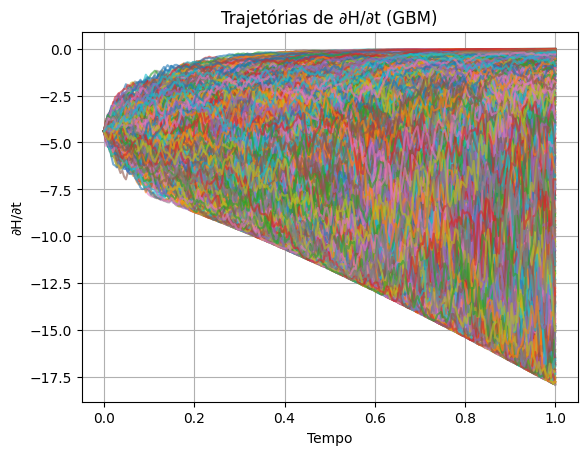

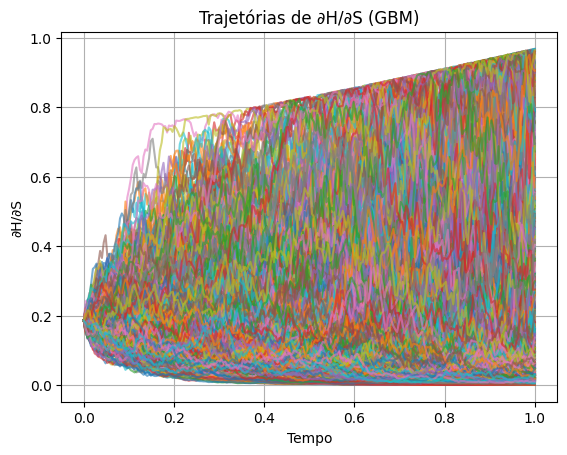

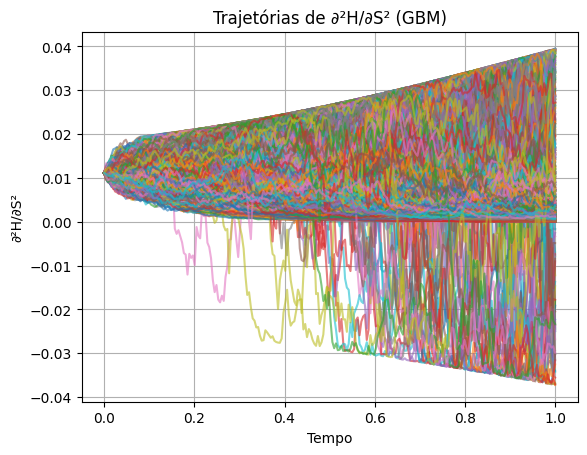

In [30]:
#------------------------
# Preparação: converter para numpy
# -----------------------------
if isinstance(t_grid, torch.Tensor):
    t_plot = t_grid.detach().cpu().numpy()          # (steps_,)
else:
    t_plot = np.asarray(t_grid)

H_np    = H_vals.detach().cpu().numpy()             # (M_, steps_)
H_t_np  = H_t_vals.detach().cpu().numpy()
H_S_np  = H_S_vals.detach().cpu().numpy()
H_SS_np = H_SS_vals.detach().cpu().numpy()

num_paths_to_plot = M   # ajuste se quiser mais/menos paths

# -----------------------------
# 1) H(t, S_t)
# -----------------------------
plt.figure()
for m in range(min(num_paths_to_plot, H_np.shape[0])):
    plt.plot(t_plot, H_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("H(t, S_t)")
plt.title("Trajetórias de H(t, S_t) (GBM)")
plt.grid(True)

# -----------------------------
# 2) ∂H/∂t
# -----------------------------
plt.figure()
for m in range(min(num_paths_to_plot, H_t_np.shape[0])):
    plt.plot(t_plot, H_t_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("∂H/∂t")
plt.title("Trajetórias de ∂H/∂t (GBM)")
plt.grid(True)

# -----------------------------
# 3) ∂H/∂S
# -----------------------------
plt.figure()
for m in range(min(num_paths_to_plot, H_S_np.shape[0])):
    plt.plot(t_plot, H_S_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("∂H/∂S")
plt.title("Trajetórias de ∂H/∂S (GBM)")
plt.grid(True)

# -----------------------------
# 4) ∂²H/∂S²
# -----------------------------
plt.figure()
for m in range(min(num_paths_to_plot, H_SS_np.shape[0])):
    plt.plot(t_plot, H_SS_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("∂²H/∂S²")
plt.title("Trajetórias de ∂²H/∂S² (GBM)")
plt.grid(True)

plt.show()


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

# ============================================================
# 1) Dados a partir das paths de Heston já simuladas
#    (supõe S_heston, v_heston, t0, T, K definidos em numpy)
# ============================================================

# Conversão para tensores
S_paths = torch.from_numpy(S_heston).float()        # (M, steps)
v_paths = torch.from_numpy(v_heston).float()        # (M, steps)
M_, steps_ = S_paths.shape

# Grade de tempo compatível
t_grid = torch.linspace(t0, T, steps_)              # (steps,)

# Payoff terminal em cada trajetória (ex: call europeia em S_T)
S_T = S_paths[:, -1]                                # (M,)
payoff_T = torch.clamp(S_T - K, min=0.0)            # G(S_T)

# Construir dataset (t, S_t, v_t) -> G(S_T)
t_list = []
S_list = []
v_list = []
Y_list = []

for m in range(M_):
    for i in range(steps_):
        t_list.append(t_grid[i])
        S_list.append(S_paths[m, i])
        v_list.append(v_paths[m, i])
        Y_list.append(payoff_T[m])                  # mesmo alvo para todos os t daquela path

t_tensor = torch.stack(t_list)[:, None]             # (M*steps, 1)
S_tensor = torch.stack(S_list)[:, None]             # (M*steps, 1)
v_tensor = torch.stack(v_list)[:, None]             # (M*steps, 1)

X_tensor = torch.cat([t_tensor, S_tensor, v_tensor], dim=1)  # (M*steps, 3)
Y_tensor = torch.stack(Y_list)[:, None]                      # (M*steps, 1)

# ============================================================
# 2) Rede neural para H(t,S,v)
# ============================================================

class NetHeston(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model_heston = NetHeston()
optimizer = optim.Adam(model_heston.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ============================================================
# 3) Treinamento
# ============================================================

batch_size = 2048
n_epochs = 50

dataset = torch.utils.data.TensorDataset(X_tensor, Y_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(n_epochs):
    for X_batch, Y_batch in loader:
        pred = model_heston(X_batch)
        loss = loss_fn(pred, Y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # opcional: print(f"Epoch {epoch+1}, loss = {loss.item():.6f}")

# ============================================================
# 4) Cálculo de H, dH/dt, dH/dS, dH/dv, d²H/dS², d²H/dv², d²H/(dS dv)
#    em todos os pontos (t_i, S_t, v_t)
# ============================================================

# Clonar tensores e marcar grad
t_flat = t_tensor.clone().detach().requires_grad_(True)   # (M*steps, 1)
S_flat = S_tensor.clone().detach().requires_grad_(True)   # (M*steps, 1)
v_flat = v_tensor.clone().detach().requires_grad_(True)   # (M*steps, 1)

X_flat = torch.cat([t_flat, S_flat, v_flat], dim=1)       # (M*steps, 3)

# H(t,S,v)
H_flat = model_heston(X_flat)                             # (M*steps, 1)

# Primeiras derivadas: dH/dt, dH/dS, dH/dv
dH_dt_flat, dH_dS_flat, dH_dv_flat = torch.autograd.grad(
    outputs=H_flat.sum(),
    inputs=[t_flat, S_flat, v_flat],
    create_graph=True                                     # necessário para 2ª ordem
)

# Segundas derivadas:
# d²H/dS²
d2H_dS2_flat = torch.autograd.grad(
    outputs=dH_dS_flat.sum(),
    inputs=S_flat,
    create_graph=True
)[0]

# d²H/dv²
d2H_dv2_flat = torch.autograd.grad(
    outputs=dH_dv_flat.sum(),
    inputs=v_flat,
    create_graph=True
)[0]

# d²H/(dS dv)  (derivar dH/dS em relação a v)
d2H_dSdv_flat = torch.autograd.grad(
    outputs=dH_dS_flat.sum(),
    inputs=v_flat
)[0]

# Remodelar tudo para (M, steps)
H_vals_heston      = H_flat.detach().view(M_, steps_)       # H(t, S_t, v_t)
H_t_vals_heston    = dH_dt_flat.detach().view(M_, steps_)   # ∂H/∂t
H_S_vals_heston    = dH_dS_flat.detach().view(M_, steps_)   # ∂H/∂S
H_v_vals_heston    = dH_dv_flat.detach().view(M_, steps_)   # ∂H/∂v
H_SS_vals_heston   = d2H_dS2_flat.detach().view(M_, steps_) # ∂²H/∂S²
H_vv_vals_heston   = d2H_dv2_flat.detach().view(M_, steps_) # ∂²H/∂v²
H_Sv_vals_heston   = d2H_dSdv_flat.detach().view(M_, steps_)# ∂²H/(∂S∂v)


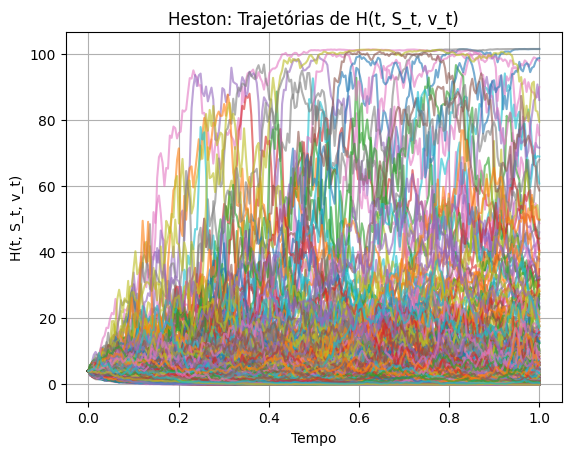

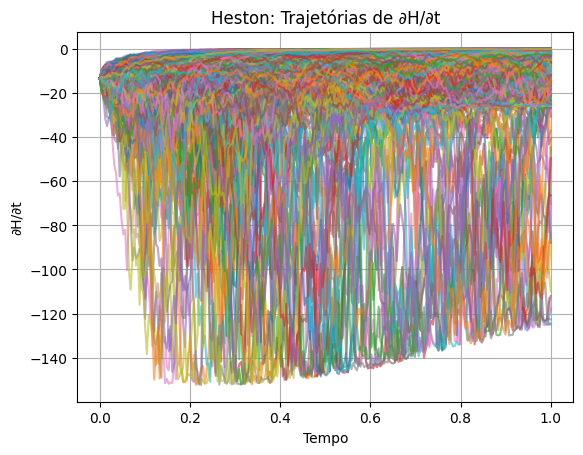

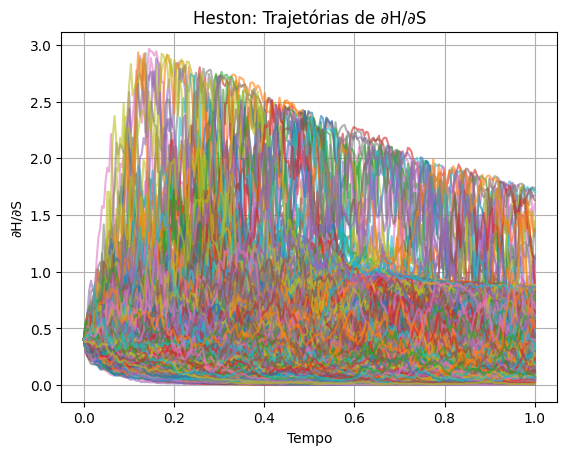

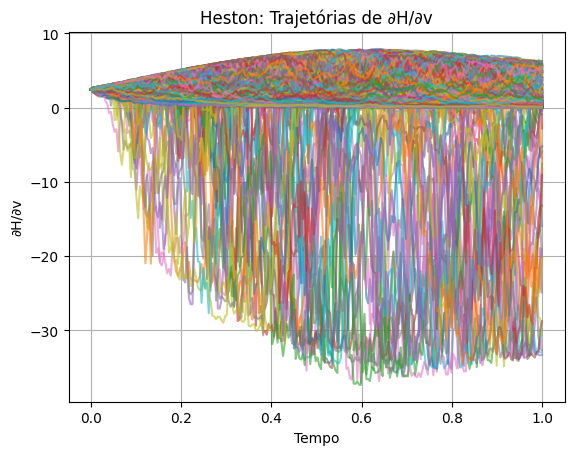

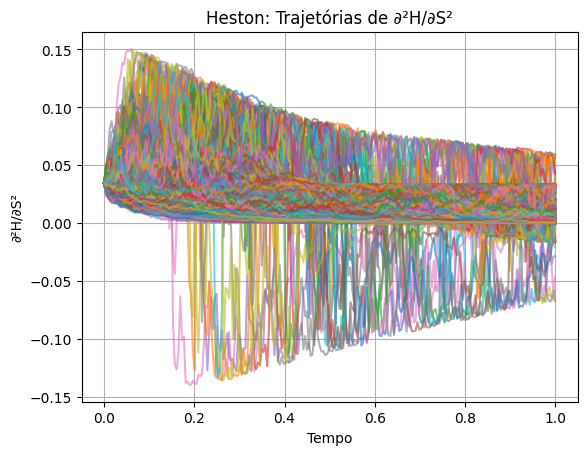

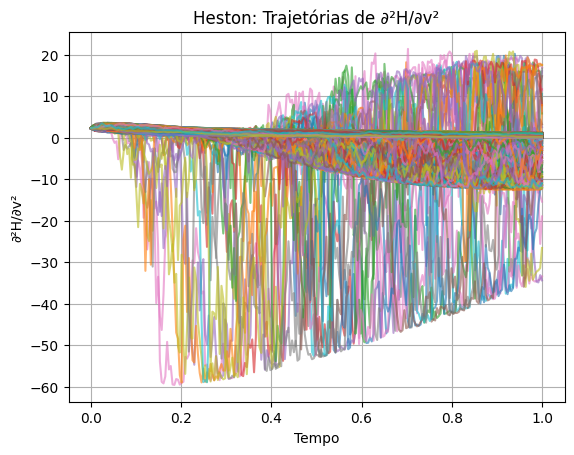

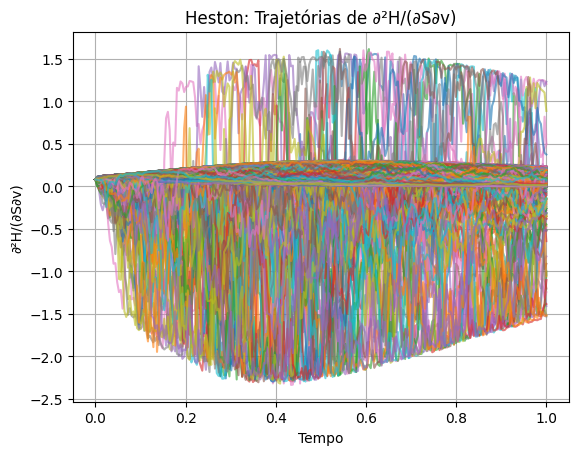

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# Gráficos para Heston: H e derivadas
# (usa variáveis: t_grid, H_vals_heston, H_t_vals_heston,
#  H_S_vals_heston, H_v_vals_heston,
#  H_SS_vals_heston, H_vv_vals_heston, H_Sv_vals_heston)
# ============================================

# Converter tudo para numpy
if isinstance(t_grid, torch.Tensor):
    t_plot = t_grid.detach().cpu().numpy()
else:
    t_plot = np.asarray(t_grid)

H_np    = H_vals_heston.detach().cpu().numpy()
H_t_np  = H_t_vals_heston.detach().cpu().numpy()
H_S_np  = H_S_vals_heston.detach().cpu().numpy()
H_v_np  = H_v_vals_heston.detach().cpu().numpy()
H_SS_np = H_SS_vals_heston.detach().cpu().numpy()
H_vv_np = H_vv_vals_heston.detach().cpu().numpy()
H_Sv_np = H_Sv_vals_heston.detach().cpu().numpy()

num_paths_to_plot = M  # ajuste se quiser mais/menos paths
npaths = min(num_paths_to_plot, H_np.shape[0])

# 1) H(t, S_t, v_t)
plt.figure()
for m in range(npaths):
    plt.plot(t_plot, H_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("H(t, S_t, v_t)")
plt.title("Heston: Trajetórias de H(t, S_t, v_t)")
plt.grid(True)

# 2) ∂H/∂t
plt.figure()
for m in range(npaths):
    plt.plot(t_plot, H_t_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("∂H/∂t")
plt.title("Heston: Trajetórias de ∂H/∂t")
plt.grid(True)

# 3) ∂H/∂S
plt.figure()
for m in range(npaths):
    plt.plot(t_plot, H_S_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("∂H/∂S")
plt.title("Heston: Trajetórias de ∂H/∂S")
plt.grid(True)

# 4) ∂H/∂v
plt.figure()
for m in range(npaths):
    plt.plot(t_plot, H_v_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("∂H/∂v")
plt.title("Heston: Trajetórias de ∂H/∂v")
plt.grid(True)

# 5) ∂²H/∂S²
plt.figure()
for m in range(npaths):
    plt.plot(t_plot, H_SS_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("∂²H/∂S²")
plt.title("Heston: Trajetórias de ∂²H/∂S²")
plt.grid(True)

# 6) ∂²H/∂v²
plt.figure()
for m in range(npaths):
    plt.plot(t_plot, H_vv_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("∂²H/∂v²")
plt.title("Heston: Trajetórias de ∂²H/∂v²")
plt.grid(True)

# 7) ∂²H/(∂S∂v)
plt.figure()
for m in range(npaths):
    plt.plot(t_plot, H_Sv_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("∂²H/(∂S∂v)")
plt.title("Heston: Trajetórias de ∂²H/(∂S∂v)")
plt.grid(True)

plt.show()


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

# ============================================================
# 1) Dados a partir das paths de Merton Jump-Diffusion já simuladas
#    Supõe que você já tem em numpy:
#       S_jump   : (M, steps)
#       J        : (M, steps-1)   # tamanhos de salto lognormal
#       dN_jump  : (M, steps-1)   # incrementos de Poisson (0 ou 1)
#       t0, T, K
# ============================================================

# Conversão para tensores
S_paths = torch.from_numpy(S_jump).float()          # (M, steps)
M_, steps_ = S_paths.shape

# Grade de tempo compatível
t_grid = torch.linspace(t0, T, steps_)              # (steps,)

# Payoff terminal em cada trajetória (ex: call europeia)
S_T = S_paths[:, -1]                                # (M,)
payoff_T = torch.clamp(S_T - K, min=0.0)            # G(S_T)

# Construir dataset (t, S_t) -> G(S_T)
t_list = []
S_list = []
Y_list = []

for m in range(M_):
    for i in range(steps_):
        t_list.append(t_grid[i])
        S_list.append(S_paths[m, i])
        Y_list.append(payoff_T[m])                  # mesmo alvo para todos os t daquela path

t_tensor = torch.stack(t_list)[:, None]             # (M*steps, 1)
S_tensor = torch.stack(S_list)[:, None]             # (M*steps, 1)

X_tensor = torch.cat([t_tensor, S_tensor], dim=1)   # (M*steps, 2)
Y_tensor = torch.stack(Y_list)[:, None]             # (M*steps, 1)

# ============================================================
# 2) Rede neural para H(t,S) no modelo com saltos
# ============================================================

class NetJump(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

model_jump = NetJump()
optimizer = optim.Adam(model_jump.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ============================================================
# 3) Treinamento
# ============================================================

batch_size = 2048
n_epochs = 50

dataset = torch.utils.data.TensorDataset(X_tensor, Y_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(n_epochs):
    for X_batch, Y_batch in loader:
        pred = model_jump(X_batch)
        loss = loss_fn(pred, Y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # opcional: print(f"Epoch {epoch+1}, loss = {loss.item():.6f}")

# ============================================================
# 4) H, dH/dt, dH/dS e d²H/dS² em todos os pontos (t_i, S_t)
# ============================================================

# Clonar tensores e marcar grad
t_flat = t_tensor.clone().detach().requires_grad_(True)    # (M*steps, 1)
S_flat = S_tensor.clone().detach().requires_grad_(True)    # (M*steps, 1)

X_flat = torch.cat([t_flat, S_flat], dim=1)                # (M*steps, 2)

# H(t,S)
H_flat = model_jump(X_flat)                                # (M*steps, 1)

# Primeiras derivadas: dH/dt e dH/dS
dH_dt_flat, dH_dS_flat = torch.autograd.grad(
    outputs=H_flat.sum(),
    inputs=[t_flat, S_flat],
    create_graph=True                                      # para 2ª ordem
)

# Segunda derivada em S: d²H/dS²
d2H_dS2_flat = torch.autograd.grad(
    outputs=dH_dS_flat.sum(),
    inputs=S_flat
)[0]

# Remodelar para (M, steps)
H_vals_jump    = H_flat.detach().view(M_, steps_)          # H(t, S_t)
H_t_vals_jump  = dH_dt_flat.detach().view(M_, steps_)      # ∂H/∂t
H_S_vals_jump  = dH_dS_flat.detach().view(M_, steps_)      # ∂H/∂S
H_SS_vals_jump = d2H_dS2_flat.detach().view(M_, steps_)    # ∂²H/∂S²

# ============================================================
# 5) Termo de salto: H(t, J S_{t-}) - H(t, S_{t-}) - H_S(t,S_{t-}) S_{t-}(J-1)
#    Avaliado nos instantes de salto discretizados
# ============================================================

# Tensores das variáveis de salto (steps-1 porque atuam no intervalo [t_{i-1}, t_i])
J_paths   = torch.from_numpy(J).float()                    # (M, steps-1)
dN_paths  = torch.from_numpy(dN_jump).float()              # (M, steps-1)
S_minus   = torch.from_numpy(S_jump[:, :-1]).float()       # S_{t-} ≈ S_{i-1} (M, steps-1)

# Tempo correspondente a cada passo (usar t_i, i=1..steps-1)
t_steps = t_grid[1:]                                       # (steps-1,)

# Construir tensores flatten
t_jump_list = []
S_minus_list = []
JS_minus_list = []

for m in range(M_):
    for i in range(steps_ - 1):
        t_jump_list.append(t_steps[i])
        S_minus_list.append(S_minus[m, i])
        JS_minus_list.append(J_paths[m, i] * S_minus[m, i])

t_jump_flat    = torch.stack(t_jump_list)[:, None]         # (M*(steps-1), 1)
S_minus_flat   = torch.stack(S_minus_list)[:, None]        # (M*(steps-1), 1)
JS_minus_flat  = torch.stack(JS_minus_list)[:, None]       # (M*(steps-1), 1)

# H(t, S_{t-})
t_minus_flat = t_jump_flat.clone().detach().requires_grad_(True)
S_minus_for_grad = S_minus_flat.clone().detach().requires_grad_(True)
X_minus = torch.cat([t_minus_flat, S_minus_for_grad], dim=1)
H_minus_flat = model_jump(X_minus)

# ∂H/∂S(t, S_{t-})
dH_dS_minus_flat = torch.autograd.grad(
    outputs=H_minus_flat.sum(),
    inputs=S_minus_for_grad
)[0]

# H(t, J S_{t-})
X_JS = torch.cat([t_jump_flat, JS_minus_flat], dim=1)
H_JS_flat = model_jump(X_JS)

# Termo de salto Xi(t) = H(t, J S_{t-}) - H(t, S_{t-}) - H_S(t,S_{t-}) S_{t-}(J-1)
J_flat = J_paths.reshape(-1, 1)
Xi_flat = H_JS_flat - H_minus_flat - dH_dS_minus_flat * S_minus_flat * (J_flat - 1.0)

# Remodelar para (M, steps-1) e alinhar com a malha de tempo
Xi_vals_jump = Xi_flat.detach().view(M_, steps_ - 1)       # termo entre colchetes
dN_vals_jump = dN_paths                                    # para multiplicar Xi * dN

# Se quiser alinhar com (M, steps) (incluindo t0), pode prefixar uma coluna de zeros:
Xi_vals_jump_full = torch.zeros((M_, steps_))
Xi_vals_jump_full[:, 1:] = Xi_vals_jump


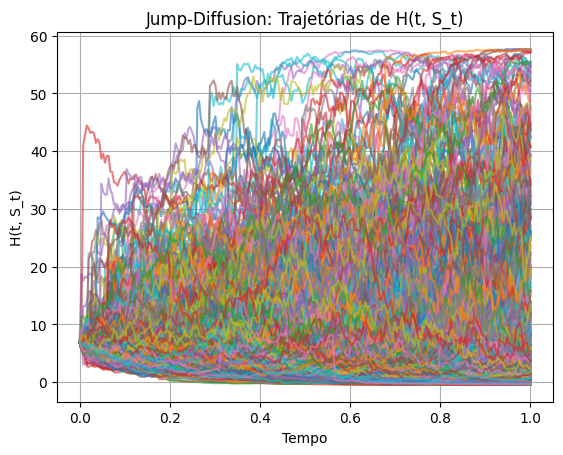

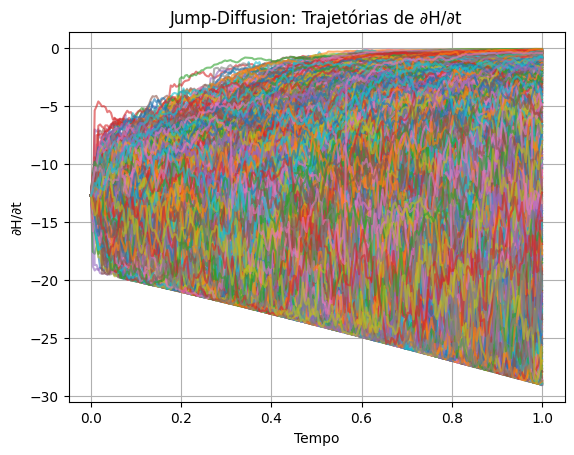

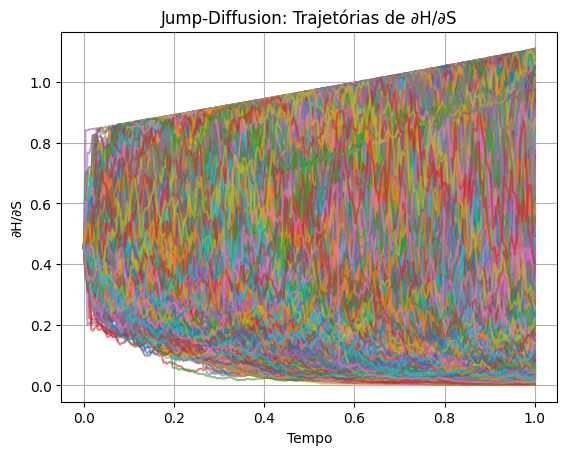

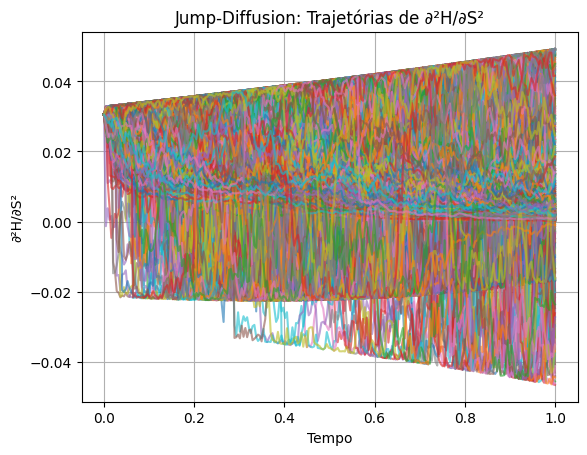

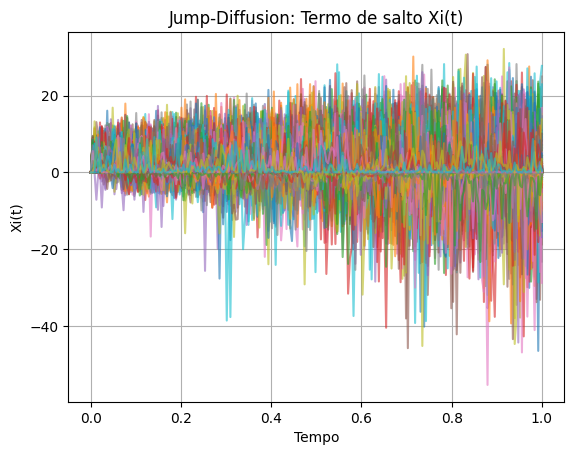

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# Gráficos para Jump-Diffusion (Merton)
# Usa:
#   t_grid
#   H_vals_jump, H_t_vals_jump, H_S_vals_jump, H_SS_vals_jump
#   Xi_vals_jump_full  (termo de salto entre colchetes)
# ============================================

# Converter para numpy
if isinstance(t_grid, torch.Tensor):
    t_plot = t_grid.detach().cpu().numpy()
else:
    t_plot = np.asarray(t_grid)

H_np    = H_vals_jump.detach().cpu().numpy()
H_t_np  = H_t_vals_jump.detach().cpu().numpy()
H_S_np  = H_S_vals_jump.detach().cpu().numpy()
H_SS_np = H_SS_vals_jump.detach().cpu().numpy()
Xi_np   = Xi_vals_jump_full.detach().cpu().numpy()

num_paths_to_plot = M
npaths = min(num_paths_to_plot, H_np.shape[0])

# 1) H(t, S_t)
plt.figure()
for m in range(npaths):
    plt.plot(t_plot, H_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("H(t, S_t)")
plt.title("Jump-Diffusion: Trajetórias de H(t, S_t)")
plt.grid(True)

# 2) ∂H/∂t
plt.figure()
for m in range(npaths):
    plt.plot(t_plot, H_t_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("∂H/∂t")
plt.title("Jump-Diffusion: Trajetórias de ∂H/∂t")
plt.grid(True)

# 3) ∂H/∂S
plt.figure()
for m in range(npaths):
    plt.plot(t_plot, H_S_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("∂H/∂S")
plt.title("Jump-Diffusion: Trajetórias de ∂H/∂S")
plt.grid(True)

# 4) ∂²H/∂S²
plt.figure()
for m in range(npaths):
    plt.plot(t_plot, H_SS_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("∂²H/∂S²")
plt.title("Jump-Diffusion: Trajetórias de ∂²H/∂S²")
plt.grid(True)

# 5) Termo de salto Xi(t) = H(t, J S_-) - H(t, S_-) - H_S(t,S_-) S_-(J-1)
plt.figure()
for m in range(npaths):
    plt.plot(t_plot, Xi_np[m, :], alpha=0.6)
plt.xlabel("Tempo")
plt.ylabel("Xi(t)")
plt.title("Jump-Diffusion: Termo de salto Xi(t)")
plt.grid(True)

plt.show()


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

# ============================================================
# Premissas: já existem em memória (GBM + H treinado)
# ------------------------------------------------------------
# S_gbm      : np.ndarray (M, steps)         -> paths GBM
# dW_gbm     : np.ndarray (M, steps-1)       -> incrementos BM usados em S_gbm
# dt         : float
# mu, sigma  : floats
# H_vals     : torch.Tensor (M, steps)       -> H(t_i, S_t_i)
# H_t_vals   : torch.Tensor (M, steps)       -> ∂H/∂t
# H_S_vals   : torch.Tensor (M, steps)       -> ∂H/∂S
# H_SS_vals  : torch.Tensor (M, steps)       -> ∂²H/∂S²
# time_grid  : np.ndarray (steps,)           -> grade temporal
# ============================================================

# Trabalhar em float64 ajuda um pouco na estabilidade
torch.set_default_dtype(torch.float64)

device = H_vals.device

# Converte S e dW para tensores float64 no mesmo device
S_tensor = torch.from_numpy(S_gbm).to(device=device, dtype=torch.float64)     # (M, steps)
dW_tensor = torch.from_numpy(dW_gbm).to(device=device, dtype=torch.float64)   # (M, steps-1)
M, steps = S_tensor.shape

# Converte H e derivadas para float64
H_vals   = H_vals.to(dtype=torch.float64)
H_t_vals = H_t_vals.to(dtype=torch.float64)
H_S_vals = H_S_vals.to(dtype=torch.float64)
H_SS_vals= H_SS_vals.to(dtype=torch.float64)

# Grade temporal como tensor
t_grid = torch.from_numpy(time_grid).to(device=device, dtype=torch.float64)   # (steps,)

# ============================================================
# 1) Funções auxiliares
# ============================================================

def forward_L_A(h, S, H):
    """
    Esquema (A) simplificado:
        V_t = h_t * S_t
        L_t = V_t - H_t

    h, S, H: tensores (M, steps)
    """
    V = h * S              # valor do portfólio em cada tempo
    L = V - H              # lucro/residual em cada tempo
    return L



def forward_L_B(h, S, H_t, H_S, H_SS, dW, dt, mu, sigma):
    """
    Esquema (B): forward de L via SDE:
        dL_t = h_t dS_t - dH_t = b_L dt + sigma_L dW_t
    com
        b_L     = h μ S - (H_t + μ S H_S + 0.5 σ² S² H_SS)
        sigma_L = σ S (h - H_S)
    h      : (M, steps)
    S      : (M, steps)
    H_t    : (M, steps)
    H_S    : (M, steps)
    H_SS   : (M, steps)
    dW     : (M, steps-1)
    """
    M_, steps_ = S.shape
    L = torch.zeros_like(S)
    L[:, 0] = 0.0 - H_vals[:, 0]   # mesma condição de (A): V_0 = 0

    for i in range(steps_ - 1):
        S_i    = S[:, i]
        h_i    = h[:, i]
        H_t_i  = H_t[:, i]
        H_S_i  = H_S[:, i]
        H_SS_i = H_SS[:, i]

        b_L_i = h_i * mu * S_i - (H_t_i + mu * S_i * H_S_i + 0.5 * sigma**2 * S_i**2 * H_SS_i)
        sigma_L_i = sigma * S_i * (h_i - H_S_i)

        L[:, i+1] = L[:, i] + b_L_i * dt + sigma_L_i * dW[:, i]

    return L


def compute_p_T_entropic(L_T, a, L_clip=10.0):
    """
    Condição terminal do adjunto para entropic:
        p_T = a * exp(a * L_T).
    Para evitar explosão numérica, clamp em L_T.
    """
    L_T_clamped = L_T.clamp(min=-L_clip, max=L_clip)
    return a * torch.exp(a * L_T_clamped)


class NetAdjoint(nn.Module):
    def __init__(self, input_dim=3, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):
        return self.net(x)


def train_adjoint_net(L, p_T, t_grid, S,
                      n_epochs=20, batch_size=2048, lr=1e-3):
    """
    Martingale-style (gradient-based Husain): p_t = E[p_T | F_t].
    Treina N_p(t, S_t, L_t) com alvo p_T em todos os tempos da mesma trajetória.
    """
    M_, steps_ = L.shape

    t_list = []
    S_list = []
    L_list = []
    Y_list = []

    for m in range(M_):
        for i in range(steps_):
            t_list.append(t_grid[i])
            S_list.append(S[m, i])
            L_list.append(L[m, i])
            Y_list.append(p_T[m])

    t_tensor = torch.stack(t_list)[:, None]
    S_tensor = torch.stack(S_list)[:, None]
    L_tensor = torch.stack(L_list)[:, None]
    X_tensor = torch.cat([t_tensor, S_tensor, L_tensor], dim=1)
    Y_tensor = torch.stack(Y_list)[:, None]

    dataset = torch.utils.data.TensorDataset(X_tensor, Y_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = NetAdjoint(input_dim=3, hidden=64).to(X_tensor.device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(n_epochs):
        for X_batch, Y_batch in loader:
            pred = model(X_batch)
            loss = loss_fn(pred, Y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
        # opcional: print(f"[Adjoint] Epoch {epoch+1}, loss={loss.item():.4e}")

    return model


def eval_adjoint_net(model, L, t_grid, S):
    """
    Avalia p(t,S,L) em toda a malha.
    """
    model.eval()
    M_, steps_ = L.shape

    t_list = []
    S_list = []
    L_list = []

    for m in range(M_):
        for i in range(steps_):
            t_list.append(t_grid[i])
            S_list.append(S[m, i])
            L_list.append(L[m, i])

    t_tensor = torch.stack(t_list)[:, None]
    S_tensor = torch.stack(S_list)[:, None]
    L_tensor = torch.stack(L_list)[:, None]
    X_tensor = torch.cat([t_tensor, S_tensor, L_tensor], dim=1)

    with torch.no_grad():
        p_flat = model(X_tensor).view(M_, steps_)

    return p_flat


# ============================================================
# 2) Esquema de Picard com proteções numéricas
# ============================================================

a = 1.0           # aversão ao risco
K_picard = 3      # nº máx de iterações
h_max = 5.0       # clamp para magnitude do hedge
eps = 1e-8

# chute inicial: delta
h0 = H_S_vals.clone()

results = {}

for mode in ['A', 'B']:   # 'A' => L = V-H; 'B' => SDE de L
    print(f"\n=== Picard - modo {mode} ===")
    h_k = h0.clone()

    for k in range(K_picard):
        # 1) Forward de L^{(k+1)}
        if mode == 'A':
            L_k1 = forward_L_A(h_k, S_tensor, H_vals)
        else:
            L_k1 = forward_L_B(h_k, S_tensor, H_t_vals, H_S_vals, H_SS_vals,
                               dW_tensor, dt, mu, sigma)

        # Checagem de NaN/inf em L
        if not torch.isfinite(L_k1).all():
            print(f"NaN/inf em L na iteração {k+1} (modo {mode}). Abortando.")
            break

        # 2) Condição terminal do adjunto
        L_T = L_k1[:, -1]
        p_T = compute_p_T_entropic(L_T, a, L_clip=10.0)   # clamp em L_T

        # 3) Treinamento da rede do adjunto
        adj_model = train_adjoint_net(
            L_k1, p_T, t_grid, S_tensor,
            n_epochs=20, batch_size=2048, lr=1e-3
        )

        # 4) Avaliação de p_t em toda a malha
        p_vals = eval_adjoint_net(adj_model, L_k1, t_grid, S_tensor)

        # 5) Atualização do controle:
        #    h^{(k+1)} = H_S + (mu / (sigma^2 S)) * p_t
        raw_term = (mu / (sigma**2)) * (p_vals / (S_tensor + eps))
        raw_term = raw_term.clamp(min=-h_max, max=h_max)  # clamp do termo adicional
        h_k1 = H_S_vals + raw_term

        # Checagem de NaN/inf em h
        if not torch.isfinite(h_k1).all():
            print(f"NaN/inf em h_k1 na iteração {k+1} (modo {mode}). Abortando.")
            break

        diff = h_k1 - h_k
        err = torch.sqrt((diff**2).mean()).item()
        print(f"Iter {k+1}, ||h^{k+1}-h^{k}||_L2 = {err:.4e}")

        h_k = h_k1.clone()

    # guarda último estado alcançado (se rompeu antes, ainda assim salva)
    results[mode] = {
        'h_star': h_k.detach(),
        'L_star': L_k1.detach(),
        'p_star': p_vals.detach()
    }

# results['A'] e results['B'] agora contêm os controles, lucros e adjuntos




=== Picard - modo A ===
Iter 1, ||h^1-h^0||_L2 = 2.0728e+00
Iter 2, ||h^2-h^1||_L2 = 4.2426e-03
Iter 3, ||h^3-h^2||_L2 = 5.8592e-03

=== Picard - modo B ===
Iter 1, ||h^1-h^0||_L2 = 4.3925e-01
Iter 2, ||h^2-h^1||_L2 = 1.8226e+00
Iter 3, ||h^3-h^2||_L2 = 3.6327e-01



=== Modo A ===
h_star shape: torch.Size([1000, 250])
L_star shape: torch.Size([1000, 250])
p_star shape: torch.Size([1000, 250])
Mean(L_T)   = 224.760583
Std (L_T)   = 32.953517
Min/Max L_T = 173.700870 / 331.702476

=== Modo B ===
h_star shape: torch.Size([1000, 250])
L_star shape: torch.Size([1000, 250])
p_star shape: torch.Size([1000, 250])
Mean(L_T)   = 10.764523
Std (L_T)   = 40.880712
Min/Max L_T = -93.080462 / 154.529982

=== Comparação A vs B ===
Mean(L_T^A - L_T^B) = 2.139961e+02
Std (L_T^A - L_T^B) = 2.745141e+01


ValueError: x and y must have same first dimension, but have shapes (251,) and (250,)

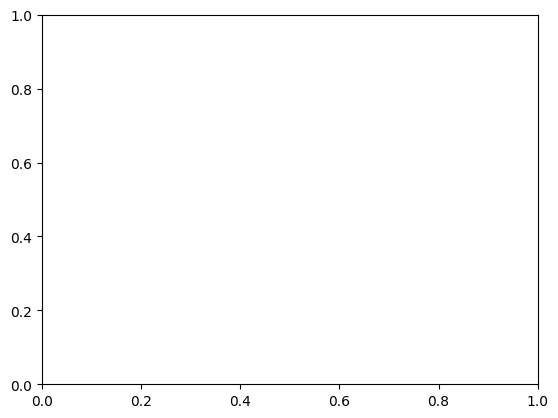

In [41]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# ------------------------------------
# 1) Shapes e estatísticas básicas
# ------------------------------------
for mode in ['A', 'B']:
    h_star = results[mode]['h_star']
    L_star = results[mode]['L_star']
    p_star = results[mode]['p_star']

    M_, steps_ = h_star.shape
    L_T = L_star[:, -1]

    print(f"\n=== Modo {mode} ===")
    print(f"h_star shape: {h_star.shape}")
    print(f"L_star shape: {L_star.shape}")
    print(f"p_star shape: {p_star.shape}")
    print(f"Mean(L_T)   = {L_T.mean().item():.6f}")
    print(f"Std (L_T)   = {L_T.std().item():.6f}")
    print(f"Min/Max L_T = {L_T.min().item():.6f} / {L_T.max().item():.6f}")

# ------------------------------------
# 2) Comparação direta A vs B em L_T
# ------------------------------------
L_T_A = results['A']['L_star'][:, -1]
L_T_B = results['B']['L_star'][:, -1]

diff_LT = L_T_A - L_T_B
print("\n=== Comparação A vs B ===")
print(f"Mean(L_T^A - L_T^B) = {diff_LT.mean().item():.6e}")
print(f"Std (L_T^A - L_T^B) = {diff_LT.std().item():.6e}")

# ------------------------------------
# 3) Gráficos: algumas trajetórias de h e L
# ------------------------------------
# tempo em numpy
t_plot = np.array(time_grid)

num_paths_to_plot = 10
for mode in ['A', 'B']:
    h_star = results[mode]['h_star']
    L_star = results[mode]['L_star']

    h_np = h_star.detach().cpu().numpy()
    L_np = L_star.detach().cpu().numpy()

    npaths = min(num_paths_to_plot, h_np.shape[0])

    # hedge
    plt.figure()
    for m in range(npaths):
        plt.plot(t_plot, h_np[m, :], alpha=0.6)
    plt.xlabel("Tempo")
    plt.ylabel("h_t")
    plt.title(f"Hedge h_t - modo {mode}")
    plt.grid(True)

    # lucro
    plt.figure()
    for m in range(npaths):
        plt.plot(t_plot, L_np[m, :], alpha=0.6)
    plt.xlabel("Tempo")
    plt.ylabel("L_t")
    plt.title(f"Lucro L_t - modo {mode}")
    plt.grid(True)

plt.show()

# ------------------------------------
# 4) Histograma de L_T para cada modo
# ------------------------------------
plt.figure()
plt.hist(L_T_A.detach().cpu().numpy(), bins=50, alpha=0.5, label='A')
plt.hist(L_T_B.detach().cpu().numpy(), bins=50, alpha=0.5, label='B')
plt.xlabel("L_T")
plt.ylabel("freq")
plt.title("Distribuição de L_T - modos A e B")
plt.legend()
plt.grid(True)
plt.show()
